In [1]:
import os

# move to project root
while True:
    # get list of directories
    dirs = os.listdir()
    if "README.md" in dirs:
        break
    else:
        os.chdir("..")
print(os.getcwd())

/home/ra/Codes/multilang_timescale


In [2]:
import json

from typing import List, Optional
import h5py

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

In [3]:
from src.trainer import Trainer
from src.settings import TrainerConfig, SubjectConfig, FeatureConfig, ResultConfig

from src.plotting import plot_timescale_flatmap

from src.utils import put_values_on_mask

In [4]:
from himalaya import kernel_ridge
from himalaya.scoring import correlation_score_split, r2_score_split
from typing import Tuple
from multiprocessing import Pool

In [5]:
result_meta_dir = ".temp/result_meta"

In [6]:
# scanning result meta json files and put it into a dataframe
result_meta_files = os.listdir(result_meta_dir)
result_meta_files = [f for f in result_meta_files if f.endswith(".json")]
## read json and cast it into ResultConfig
result_meta_list = []
for f in result_meta_files:
    with open(os.path.join(result_meta_dir, f), "r") as f:
        result_config = ResultConfig(**json.load(f))
        result_meta_list.append(result_config.dict())

result_meta_df = pd.DataFrame(result_meta_list)

# add result_meta_files to result_meta_df
result_meta_df["result_meta_file"] = [
    os.path.join(result_meta_dir, f) for f in result_meta_files
]

In [7]:
result_meta_df.head()

,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
0,.temp/config/subject/subject-07-reading.json,.temp/config/feature/mBERT-all_timescales-7-fe...,.temp/config/train/trainer_config_no_mask.json,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d8048e0,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result_meta/b413b6f3-fa17-47a6-8c84-724b...
1,.temp/config/subject/subject-07-reading.json,.temp/config/feature/BERT-all_timescales-7-fea...,.temp/config/train/trainer_config.json,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8984,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result/7904b592-f99d-44e9-befe-6c5b81ed8...,.temp/result_meta/7904b592-f99d-44e9-befe-6c5b...
2,.temp/config/subject/subject-07-reading.json,.temp/config/feature/BERT-all_timescales-7-fea...,.temp/config/train/trainer_config_no_mask.json,.temp/result/8d981213-8517-4c58-b372-4fb76942c09f,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result_meta/8d981213-8517-4c58-b372-4fb7...
3,.temp/config/subject/subject-07-reading.json,.temp/config/feature/mBERT-all_timescales-7-fe...,.temp/config/train/trainer_config.json,.temp/result/145fe775-7b59-4c6e-b037-253defdc54b8,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result/145fe775-7b59-4c6e-b037-253defdc5...,.temp/result_meta/145fe775-7b59-4c6e-b037-253d...


In [8]:
result_meta_df["trainer_config_path"].unique()

array(['.temp/config/train/trainer_config_no_mask.json',
       '.temp/config/train/trainer_config.json'], dtype=object)

In [9]:
result_meta_df["subject_config_path"].unique()

array(['.temp/config/subject/subject-07-reading.json'], dtype=object)

In [10]:
result_meta_df["feature_config_path"].unique()

array(['.temp/config/feature/mBERT-all_timescales-7-feature_config.json',
       '.temp/config/feature/BERT-all_timescales-7-feature_config.json'],
      dtype=object)

In [11]:
# select some results
selected_train_config = [".temp/config/train/trainer_config_no_mask.json"]
selected_feature_config = [
    ".temp/config/feature/BERT-all_timescales-7-feature_config.json",
    ".temp/config/feature/mBERT-all_timescales-7-feature_config.json",
]
selected_subject_config = [".temp/config/subject/subject-07-reading.json"]

# now select dataframe
selected_result_meta_df = result_meta_df.query(
    "trainer_config_path in @selected_train_config and \
                                                feature_config_path in @selected_feature_config and \
                                                subject_config_path in @selected_subject_config"
)

In [12]:
selected_result_meta_df.sort_values(['feature_config_path', 'subject_config_path', 'trainer_config_path'], inplace=True)
selected_result_meta_df.head()

/tmp/ipykernel_395766/3541877903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_result_meta_df.sort_values(['feature_config_path', 'subject_config_path', 'trainer_config_path'], inplace=True)


,subject_config_path,feature_config_path,trainer_config_path,result_dir,hyperparam_path,stats_path,plot_dir,result_meta_file
2,.temp/config/subject/subject-07-reading.json,.temp/config/feature/BERT-all_timescales-7-fea...,.temp/config/train/trainer_config_no_mask.json,.temp/result/8d981213-8517-4c58-b372-4fb76942c09f,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result/8d981213-8517-4c58-b372-4fb76942c...,.temp/result_meta/8d981213-8517-4c58-b372-4fb7...
0,.temp/config/subject/subject-07-reading.json,.temp/config/feature/mBERT-all_timescales-7-fe...,.temp/config/train/trainer_config_no_mask.json,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d8048e0,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result/b413b6f3-fa17-47a6-8c84-724b5d804...,.temp/result_meta/b413b6f3-fa17-47a6-8c84-724b...


# Refit and Evaluate

In [13]:
# # iter over selected_result_meta_df
# for i, row in selected_result_meta_df.iterrows():
#     result_config_path = row["result_meta_file"]
    
#     ## refit model 
#     print(f"Refitting model for {result_config_path}")
    
#     trainer = Trainer(result_config_json=result_config_path)
#     trainer.refit_and_evaluate()

Refitting model for .temp/result_meta/8d981213-8517-4c58-b372-4fb76942c09f.json


refitting...
predicting in batches...
computing scores...


/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:169: RuntimeWarning: divide by zero encountered in divide
  r2[fsi, :] = ((2 * inter - asst) / sst).sum(0)
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:169: RuntimeWarning: invalid value encountered in divide
  r2[fsi, :] = ((2 * inter - asst) / sst).sum(0)
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:61: RuntimeWarning: divide by zero encountered in divide
  r2 = 1. - error / var
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:61: RuntimeWarning: invalid value encountered in divide
  r2 = 1. - error / var


computing permutation test...
computing timescale selectivity...
saving stat...


/home/ra/Codes/multilang_timescale/src/utils.py:147: RuntimeWarning: invalid value encountered in divide
  normalized_scores = np.nan_to_num(nz_scores / score_sum)


Refitting model for .temp/result_meta/b413b6f3-fa17-47a6-8c84-724b5d8048e0.json
refitting...
predicting in batches...
computing scores...


/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:169: RuntimeWarning: divide by zero encountered in divide
  r2[fsi, :] = ((2 * inter - asst) / sst).sum(0)
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:169: RuntimeWarning: invalid value encountered in divide
  r2[fsi, :] = ((2 * inter - asst) / sst).sum(0)
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:61: RuntimeWarning: divide by zero encountered in divide
  r2 = 1. - error / var
/home/ra/miniconda3/envs/vem/lib/python3.11/site-packages/himalaya/scoring.py:61: RuntimeWarning: invalid value encountered in divide
  r2 = 1. - error / var


computing permutation test...
computing timescale selectivity...
saving stat...


/home/ra/Codes/multilang_timescale/src/utils.py:147: RuntimeWarning: invalid value encountered in divide
  normalized_scores = np.nan_to_num(nz_scores / score_sum)


# Plotting

In [13]:
bert_configs = selected_result_meta_df.iloc[0]
mbert_configs = selected_result_meta_df.iloc[1] 

In [14]:
subject_config = bert_configs["subject_config_path"]
subject_config = SubjectConfig(**json.load(open(subject_config, "r"))).dict()

mapper_file = subject_config['sub_fmri_mapper_path']
mapper_file = "/media/data/dataset/timescale/fmri/deniz2019_old/subject07_mappers.hdf"

bert_stats = np.load(bert_configs['stats_path'])
mbert_stats = np.load(mbert_configs['stats_path'])


In [15]:
# def get_bh_invalid_voxels(pvalues: np.ndarray, alpha: float):

#     num_values = len(pvalues)
#     pvalues_sorted = np.sort(pvalues)
#     max_p = pvalues_sorted[
#         np.argmax(
#             np.where(
#                 pvalues_sorted <= ((np.arange(1, num_values + 1) / num_values) * alpha)
#             )
#         )
#     ]
    
#     return pvalues > max_p

In [16]:
# def put_values_on_mask(
#     value_to_be_stored: np.ndarray,
#     p_values: np.ndarray,
#     ev_mask: np.ndarray,
#     alpha: float = 0.05,
#     valid_range: Tuple[float, float] = (8,256)
# ):
#     whole_voxel = np.full(ev_mask.shape, np.nan)

#     invalid_p_values = get_bh_invalid_voxels(p_values, alpha)

#     valid_values = (value_to_be_stored >= valid_range[0]) & (value_to_be_stored <= valid_range[1])
    
#     value_to_be_stored[~valid_values] = np.nan
#     value_to_be_stored[invalid_p_values] = np.nan

#     whole_voxel[ev_mask] = value_to_be_stored
    
#     valid_voxels = np.where(~np.isnan(whole_voxel)) 
#     return whole_voxel, valid_voxels

In [17]:
bert_significant_voxels, bert_valid_voxels = put_values_on_mask(
    bert_stats["test_r2_selectivity_mask"],
    bert_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)

In [18]:
mbert_significant_voxels, mbert_valid_voxels = put_values_on_mask(
    mbert_stats["test_r2_selectivity_mask"],
    mbert_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)

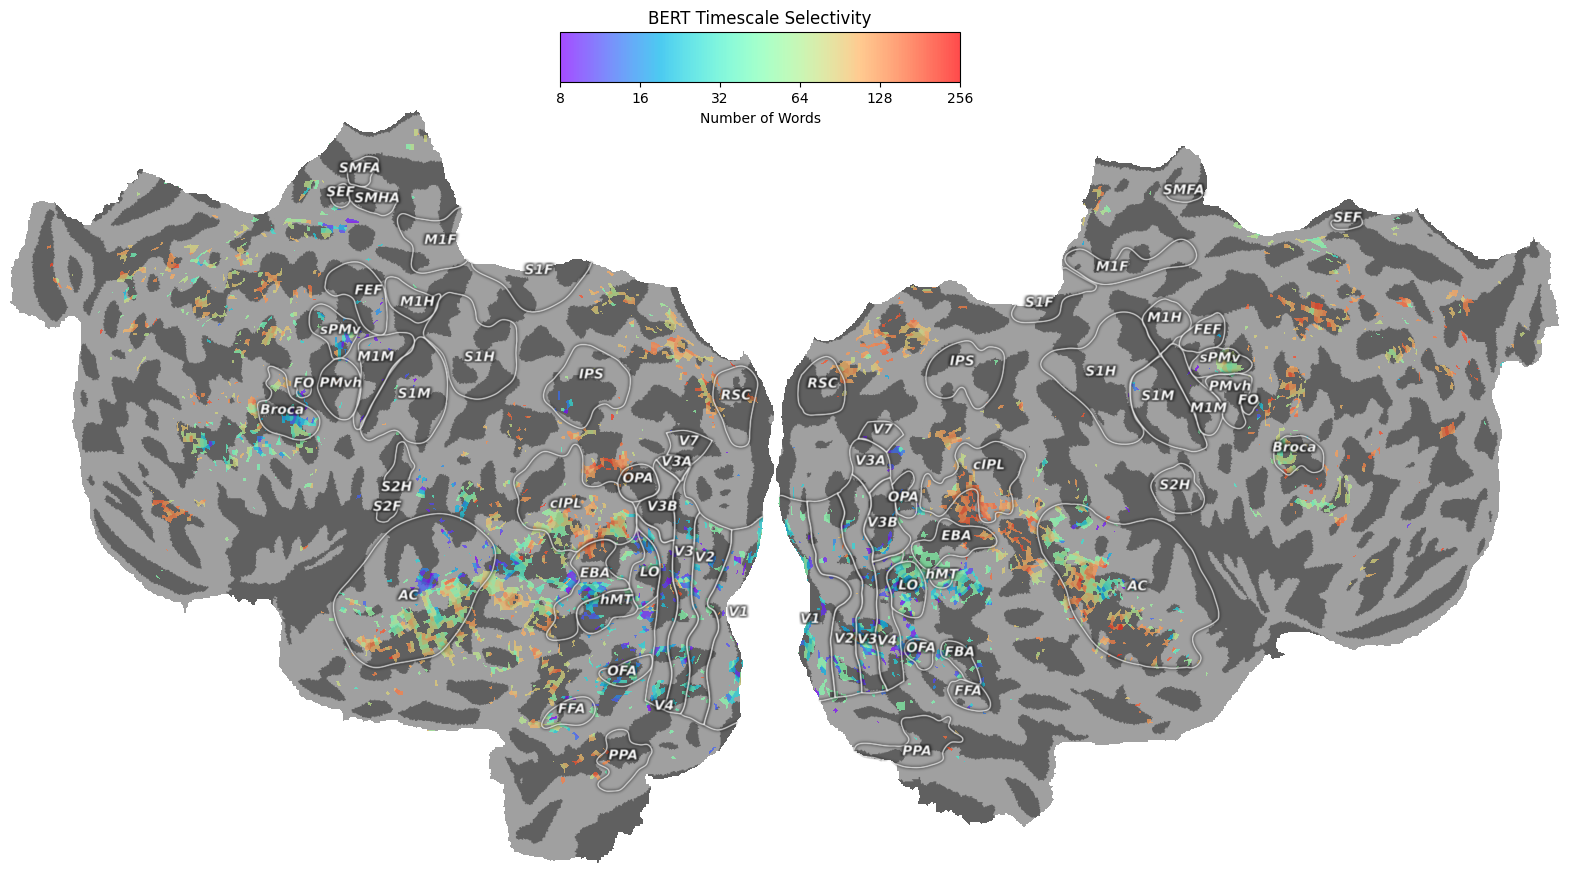

In [19]:
# plot timescale flatmap
plot_timescale_flatmap(
    bert_significant_voxels, 
    mapper_file, 
    title="BERT Timescale Selectivity", 
)

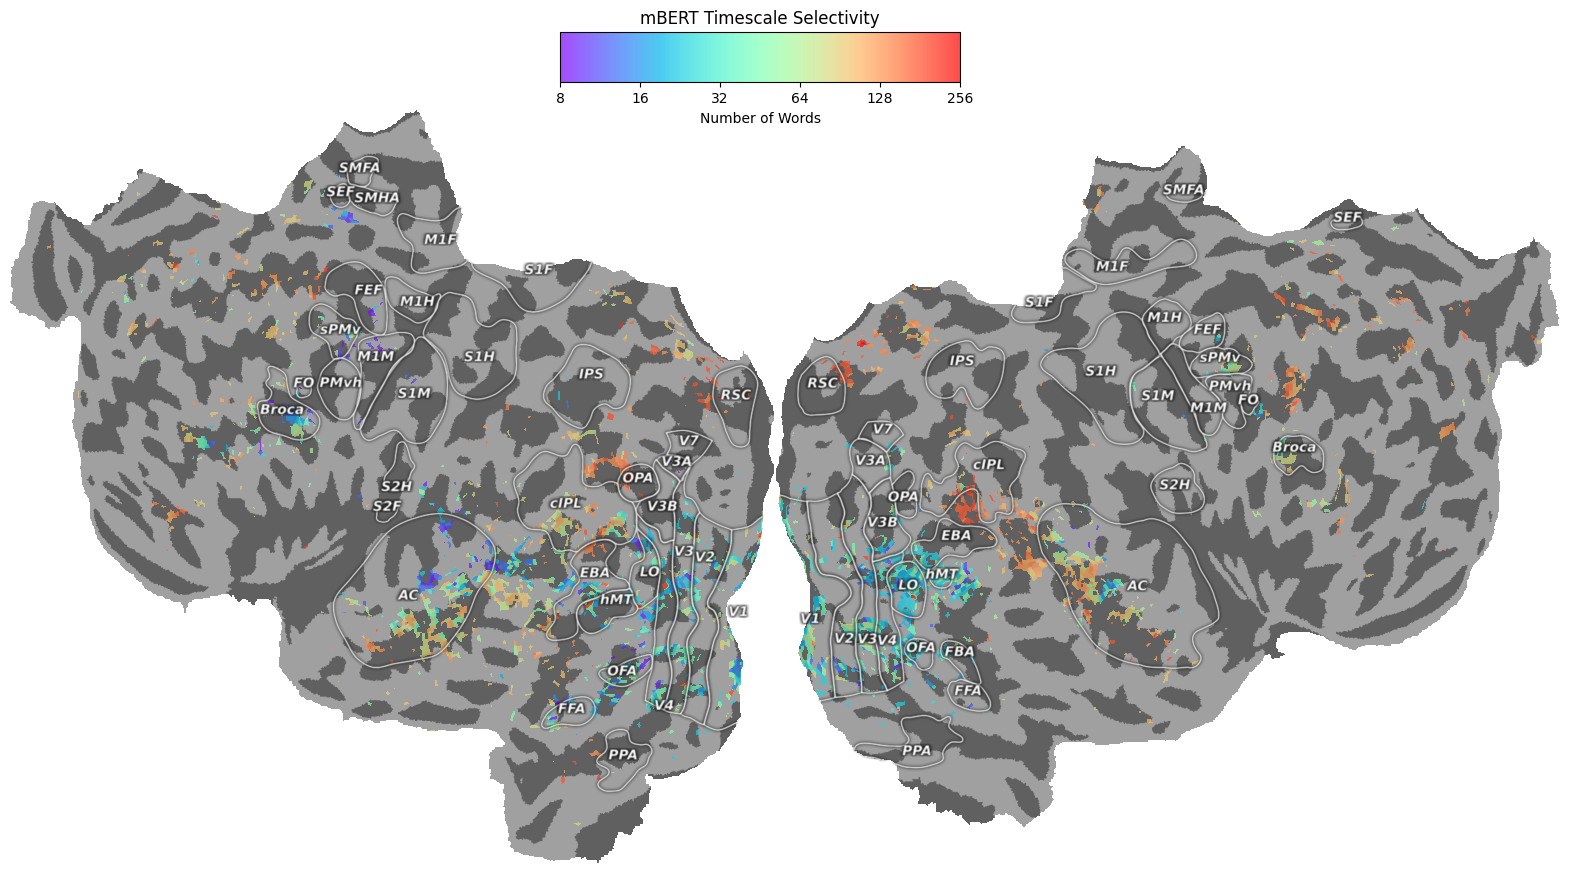

In [20]:
plot_timescale_flatmap(
    mbert_significant_voxels, 
    mapper_file, 
    title="mBERT Timescale Selectivity", 
)

In [22]:
# mask for mbert
mask_mbert = mbert_significant_voxels >= 150
mask_bert = bert_significant_voxels <=50

join_mask = mask_mbert & mask_bert

bert_with_mask = bert_significant_voxels.copy()
bert_with_mask[~join_mask] = np.nan

mbert_with_mask = mbert_significant_voxels.copy()
mbert_with_mask[~join_mask] = np.nan

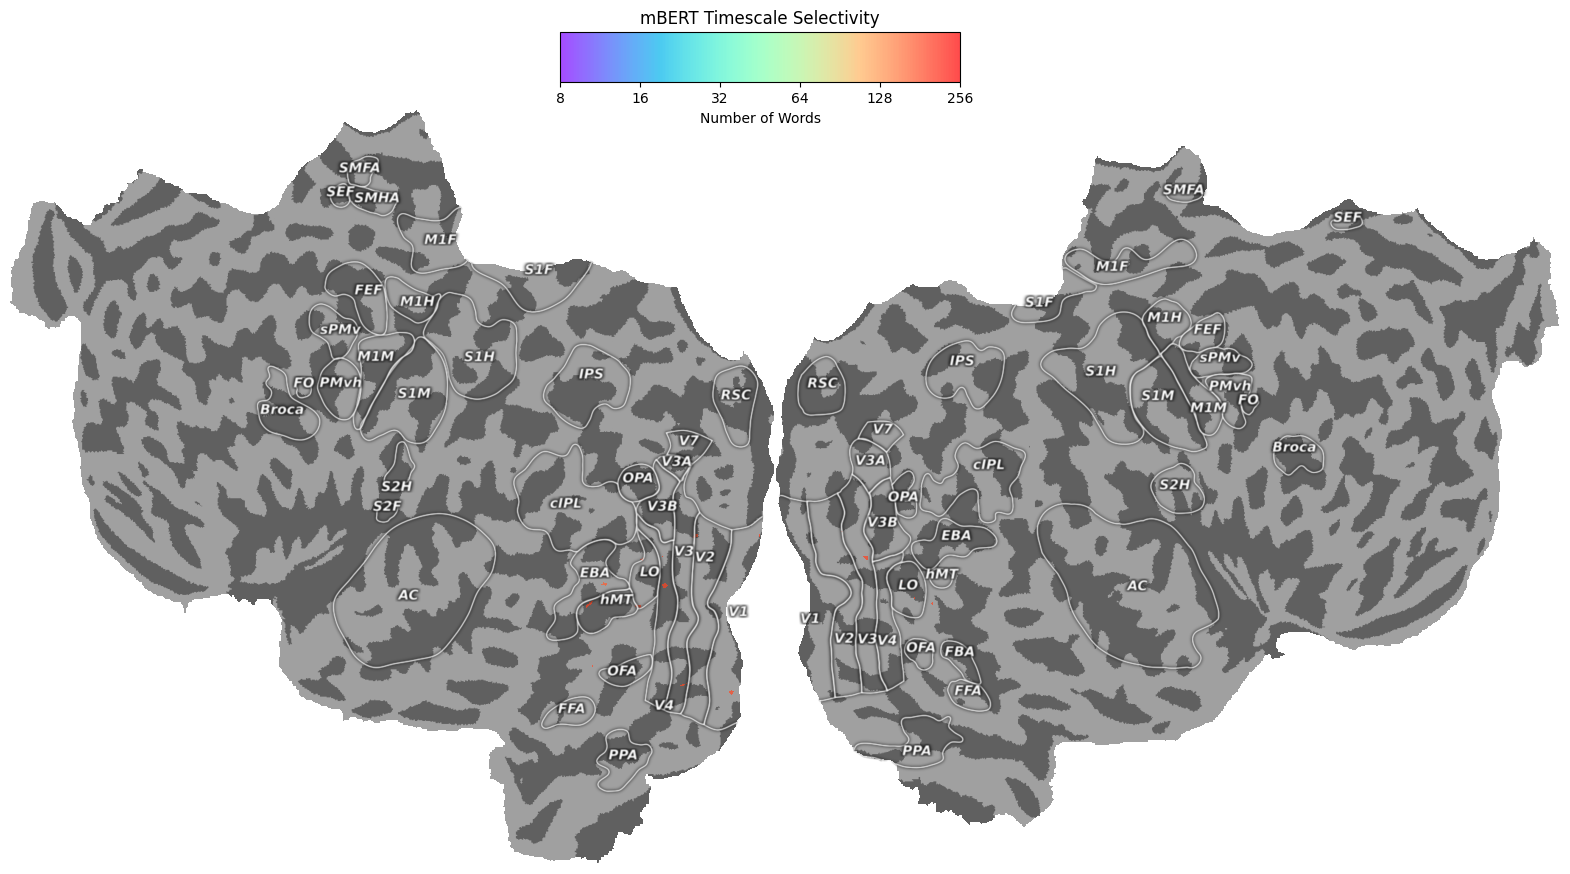

In [25]:
plot_timescale_flatmap(
    mbert_with_mask, 
    mapper_file, 
    title="mBERT Timescale Selectivity", 
)

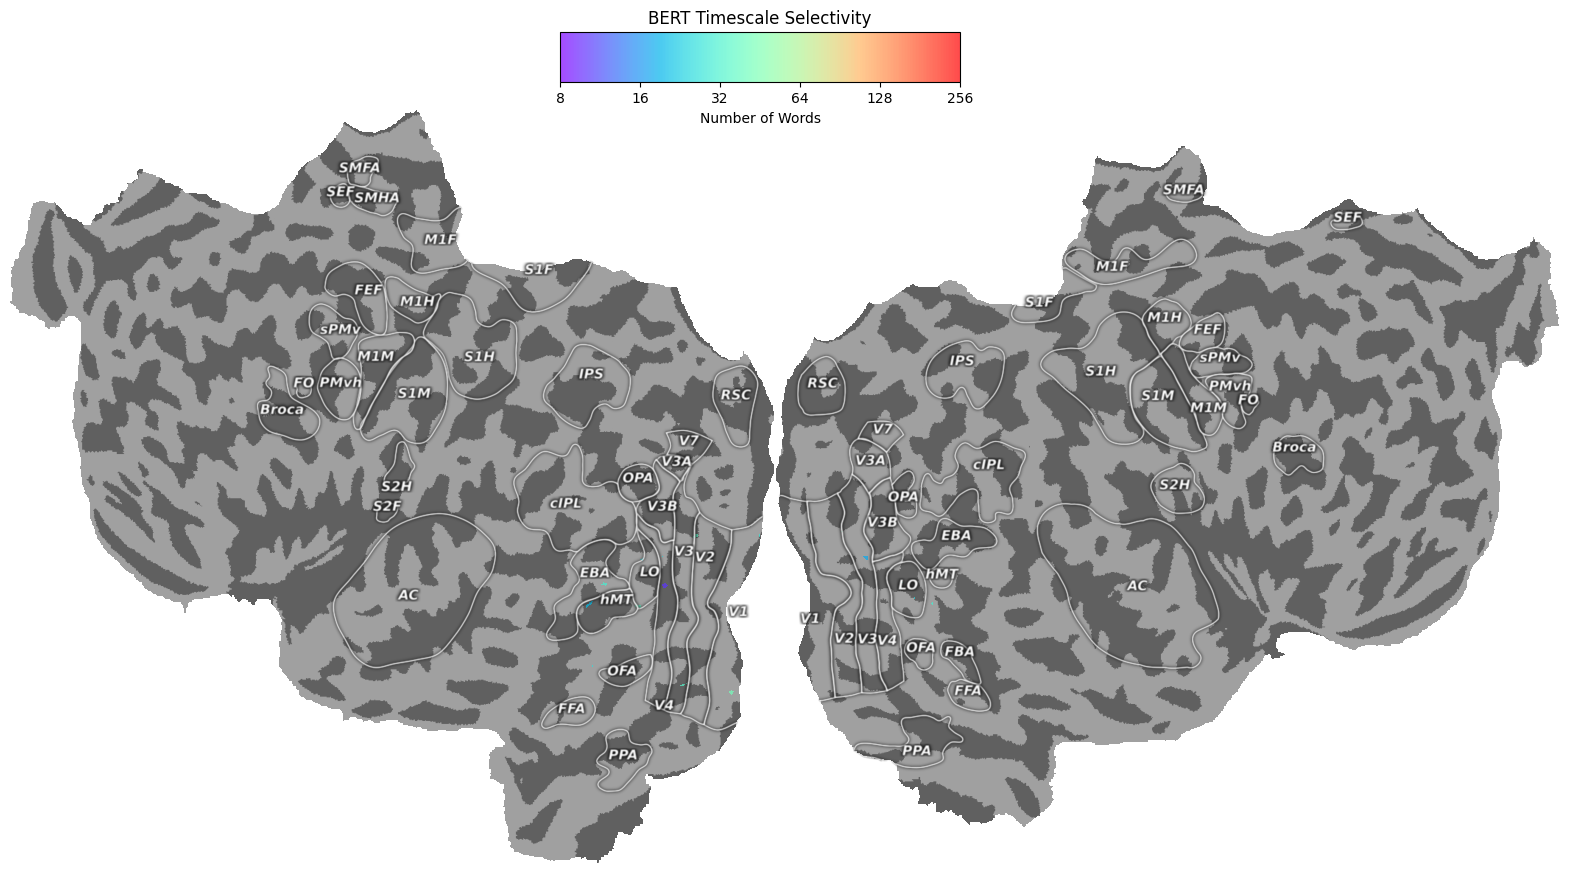

In [26]:
plot_timescale_flatmap(
    bert_with_mask, 
    mapper_file, 
    title="BERT Timescale Selectivity", 
)

In [22]:
# get the same significant voxels for both models
common_voxels = np.intersect1d(bert_valid_voxels, mbert_valid_voxels)

significant_bert_voxels = bert_significant_voxels[common_voxels]    
significant_mbert_voxels = mbert_significant_voxels[common_voxels]

diff = np.abs(significant_bert_voxels - significant_mbert_voxels)
# filter out value > 256

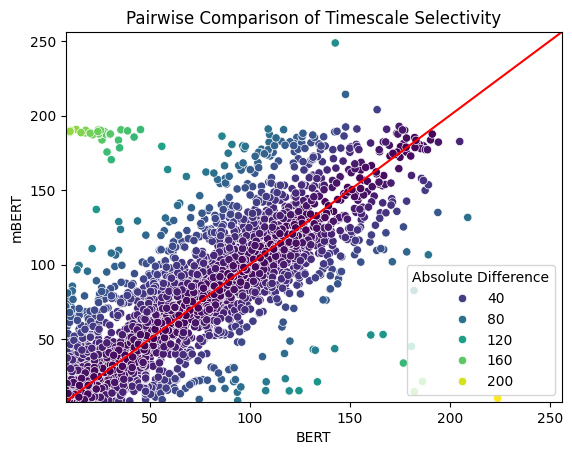

In [23]:
# scatter plot
import seaborn as sns

sns.scatterplot(x=significant_bert_voxels, y=significant_mbert_voxels, hue=diff, palette="viridis")

# add diagonal line
plt.plot([8, 256], [8, 256], color="red")

# limit axis to 200
plt.xlim(8, 256)
plt.ylim(8, 256)

plt.ylabel("mBERT")
plt.xlabel("BERT")

plt.title("Pairwise Comparison of Timescale Selectivity")

plt.legend(title="Absolute Difference", loc="lower right")

plt.show()

In [24]:
bert_stats["test_joint_r2_score_mask"]

array([ 1.1920929e-07,  0.0000000e+00, -1.1920929e-07, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [25]:
(bert_stats["test_p_values_r2_mask"] < 0.05).sum()

11248

In [26]:
prediction_accuracy_bert, bert_valid_voxels = put_values_on_mask(
    bert_stats["test_joint_r2_score_mask"],
    bert_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)

prediction_accuracy_mbert, mbert_valid_voxels = put_values_on_mask(
    mbert_stats["test_joint_r_score_mask"],
    mbert_stats["test_p_values_r2_mask"],
    ev_mask=None, alpha=0.05)


In [27]:
bert_mask = bert_stats["test_p_values_r2_mask"] < 0.05
bert_valid_voxels = np.where(bert_mask)[0]

In [28]:
mbert_mask = mbert_stats["test_p_values_r2_mask"] < 0.05
mbert_valid_voxels = np.where(mbert_mask)[0]

In [29]:
common_voxels = np.intersect1d(bert_valid_voxels, mbert_valid_voxels)

prediction_accuracy_bert = np.sqrt(bert_stats["test_joint_r2_score_mask"][common_voxels])
prediction_accuracy_mbert =  np.sqrt(mbert_stats["test_joint_r2_score_mask"][common_voxels])



diff = np.abs(prediction_accuracy_bert - prediction_accuracy_mbert)

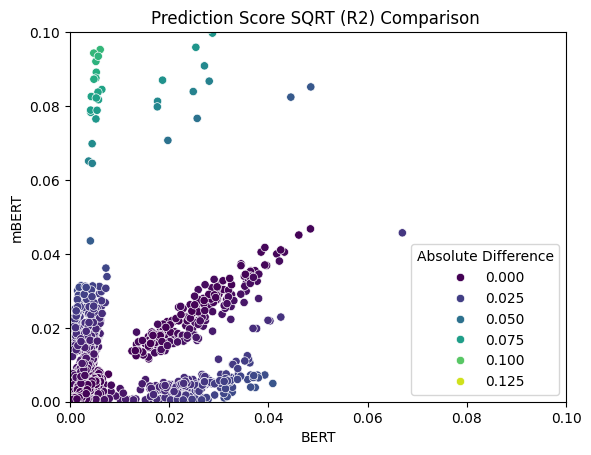

In [31]:
# scatter plot
import seaborn as sns

sns.scatterplot(x=prediction_accuracy_bert, y=prediction_accuracy_mbert, hue=diff, palette="viridis")

# add diagonal line
#plt.plot([8, 256], [8, 256], color="red")

# limit axis to 200
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)

plt.ylabel("mBERT")
plt.xlabel("BERT")

plt.title("Prediction Score SQRT (R2) Comparison ")

plt.legend(title="Absolute Difference", loc="lower right")

plt.show()